In [3]:
!pip install seaborn

In [4]:
!pip install scikit-learn

In [41]:
!pip install --upgrade --user pyqtwebengine==5.12.1

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.2.2 requires pyqt5<5.13, but you have pyqt5 5.15.10 which is incompatible.



     ---------------------------------------- 49.7/49.7 MB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 6.8/6.8 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 50.1/50.1 MB 2.0 MB/s eta 0:00:00


In [42]:
!pip install --upgrade --user pyqt5==5.12.3

     ---------------------------------------- 51.4/51.4 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: pyqt5
    Found existing installation: PyQt5 5.15.10
    Uninstalling PyQt5-5.15.10:
      Successfully uninstalled PyQt5-5.15.10


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [44]:
!pip install keras

In [9]:
!pip install tensorflow

In [10]:
!pip install tqdm

In [46]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from PIL import ImageFile
from keras.models import load_model
import shutil

#resnet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input 

# image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers ,models,optimizers

In [2]:
TEST_DIR = os.path.join(os.getcwd(),"datasets_cnn/imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"datasets_cnn/imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model_path","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)

In [3]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)
CSV_FILES_DIR = os.path.join(os.getcwd(),"csv_files")
if not os.path.exists(CSV_FILES_DIR):
    os.makedirs(CSV_FILES_DIR)
    
create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17462 entries, 0 to 17461
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   17462 non-null  object
 1   ClassName  17462 non-null  object
dtypes: object(2)
memory usage: 273.0+ KB


In [5]:
data_train['ClassName'].value_counts()

c0    1953
c4    1817
c6    1811
c3    1809
c5    1804
c2    1783
c1    1754
c9    1681
c7    1532
c8    1518
Name: ClassName, dtype: int64

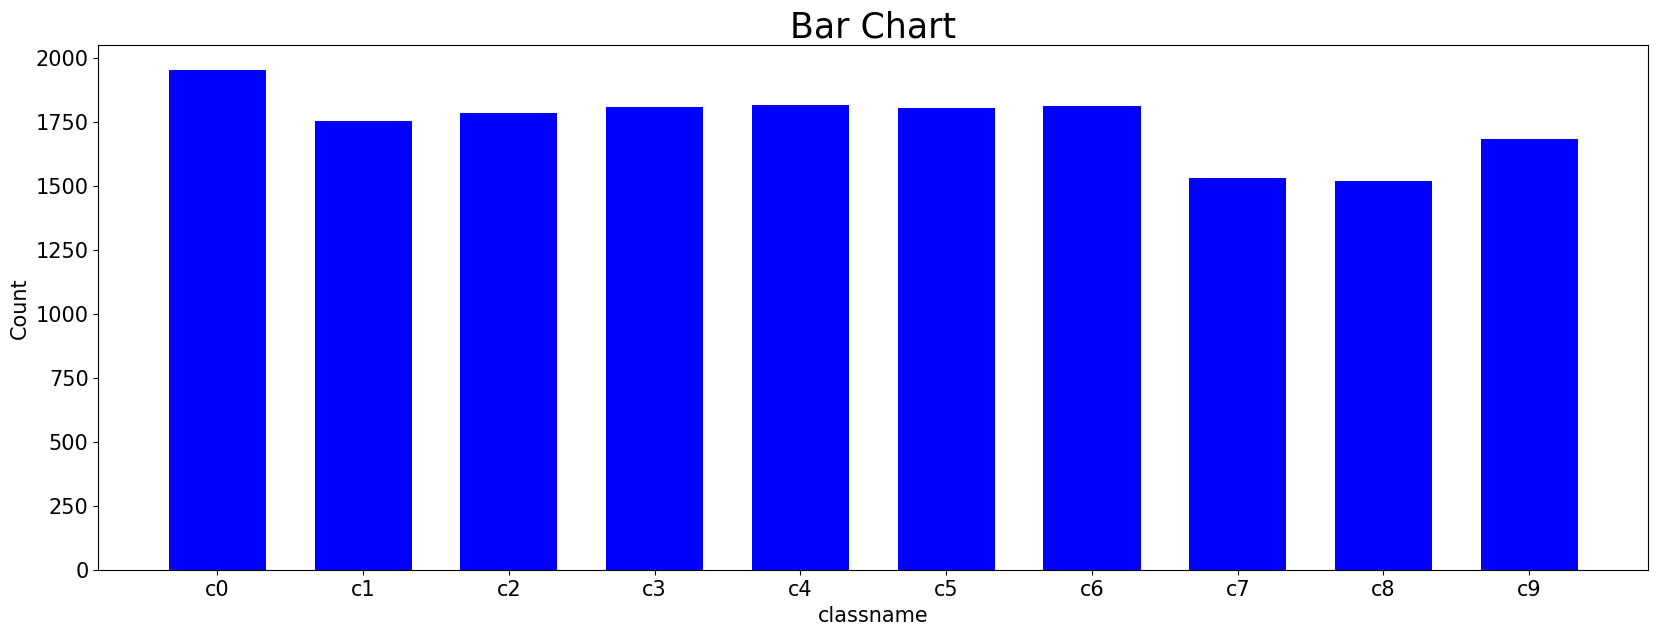

In [6]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [7]:
data_test.head()

,FileName,ClassName
0,C:\Users\Sync\datasets_cnn/imgs\test\img_10001...,test
1,C:\Users\Sync\datasets_cnn/imgs\test\img_10002...,test
2,C:\Users\Sync\datasets_cnn/imgs\test\img_10004...,test
3,C:\Users\Sync\datasets_cnn/imgs\test\img_10005...,test
4,C:\Users\Sync\datasets_cnn/imgs\test\img_10006...,test


In [8]:
data_test.shape

(4961, 2)

In [9]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c7': 0, 'c2': 1, 'c1': 2, 'c3': 3, 'c5': 4, 'c9': 5, 'c0': 6, 'c6': 7, 'c4': 8, 'c8': 9}


In [10]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [11]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(17462, 10)


In [12]:
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [13]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|██████████| 13969/13969 [00:30<00:00, 456.56it/s]


In [15]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 3493/3493 [00:10<00:00, 338.02it/s]


In [16]:
model = Sequential()
# 64 conv2d filters with relu
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2)) #Maxpool
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2)) #Maxpool
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2)) #Maxpool
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2)) #Maxpool
model.add(Dropout(0.0))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.0))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

model.summary()

C:\Users\Sync\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,663,878 (17.79 MB)

 Trainable params: 4,663,878 (17.79 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
!pip install pydot==1.2.3

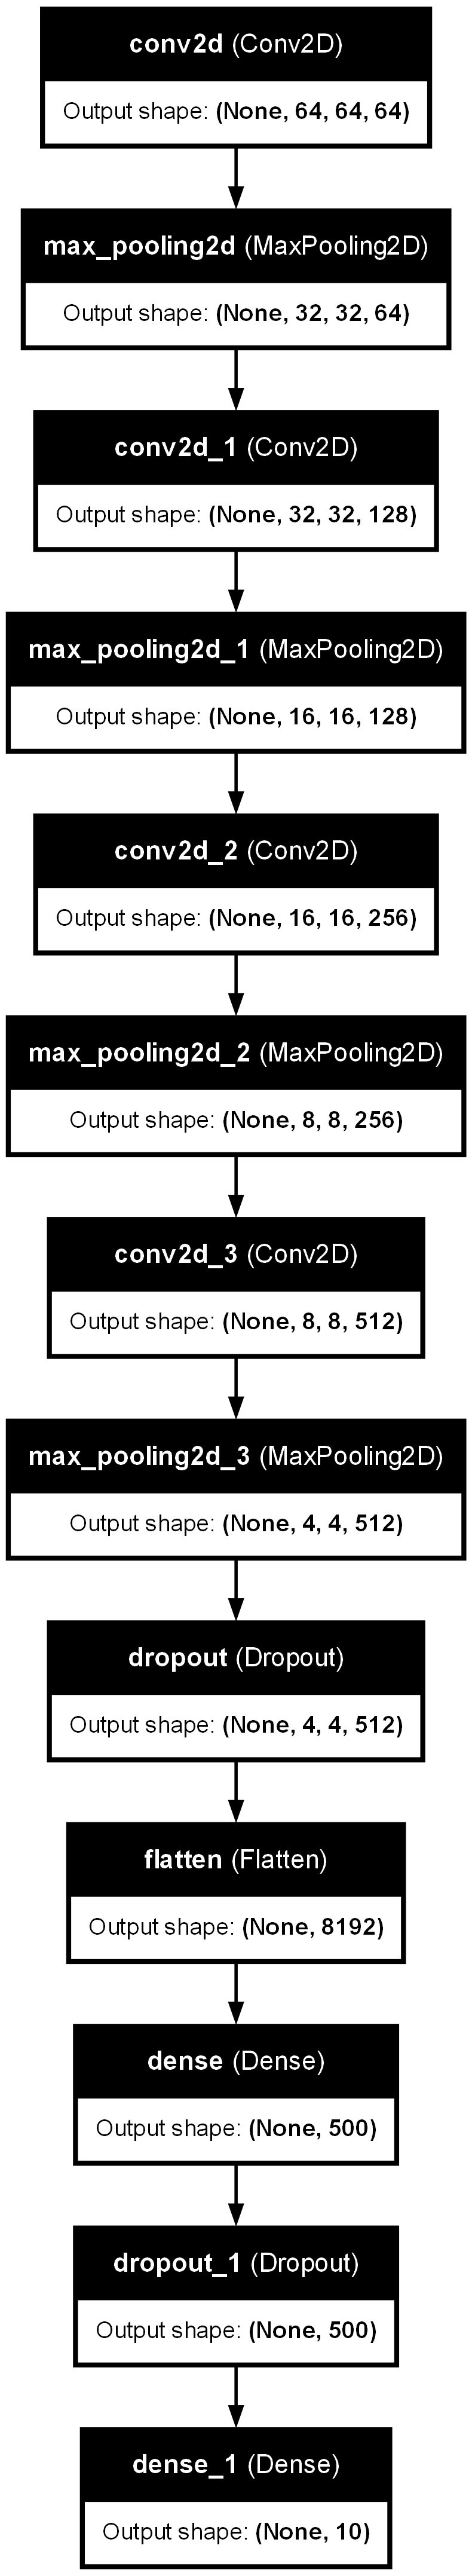

In [31]:
plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
epochs = 20
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=epochs, batch_size=40, shuffle=True)

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 63s 172ms/step - accuracy: 0.3643 - loss: 1.7245 - val_accuracy: 0.8534 - val_loss: 0.4387
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 154ms/step - accuracy: 0.9257 - loss: 0.2460 - val_accuracy: 0.9751 - val_loss: 0.1030
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.9749 - loss: 0.0926 - val_accuracy: 0.9548 - val_loss: 0.1868
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.9855 - loss: 0.0487 - val_accuracy: 0.9785 - val_loss: 0.0824
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step - accuracy: 0.9912 - loss: 0.0280 - val_accuracy: 0.9694 - val_loss: 0.1340
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 156ms/step - accuracy: 0.9926 - loss: 0.0227 - val_accuracy: 0.9851 - val_loss: 0.0675
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 159ms/step - accuracy: 0.9951 - loss: 0.0122 - val_accuracy: 0.9734 - val_loss: 0.1207
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.9944 - loss: 0

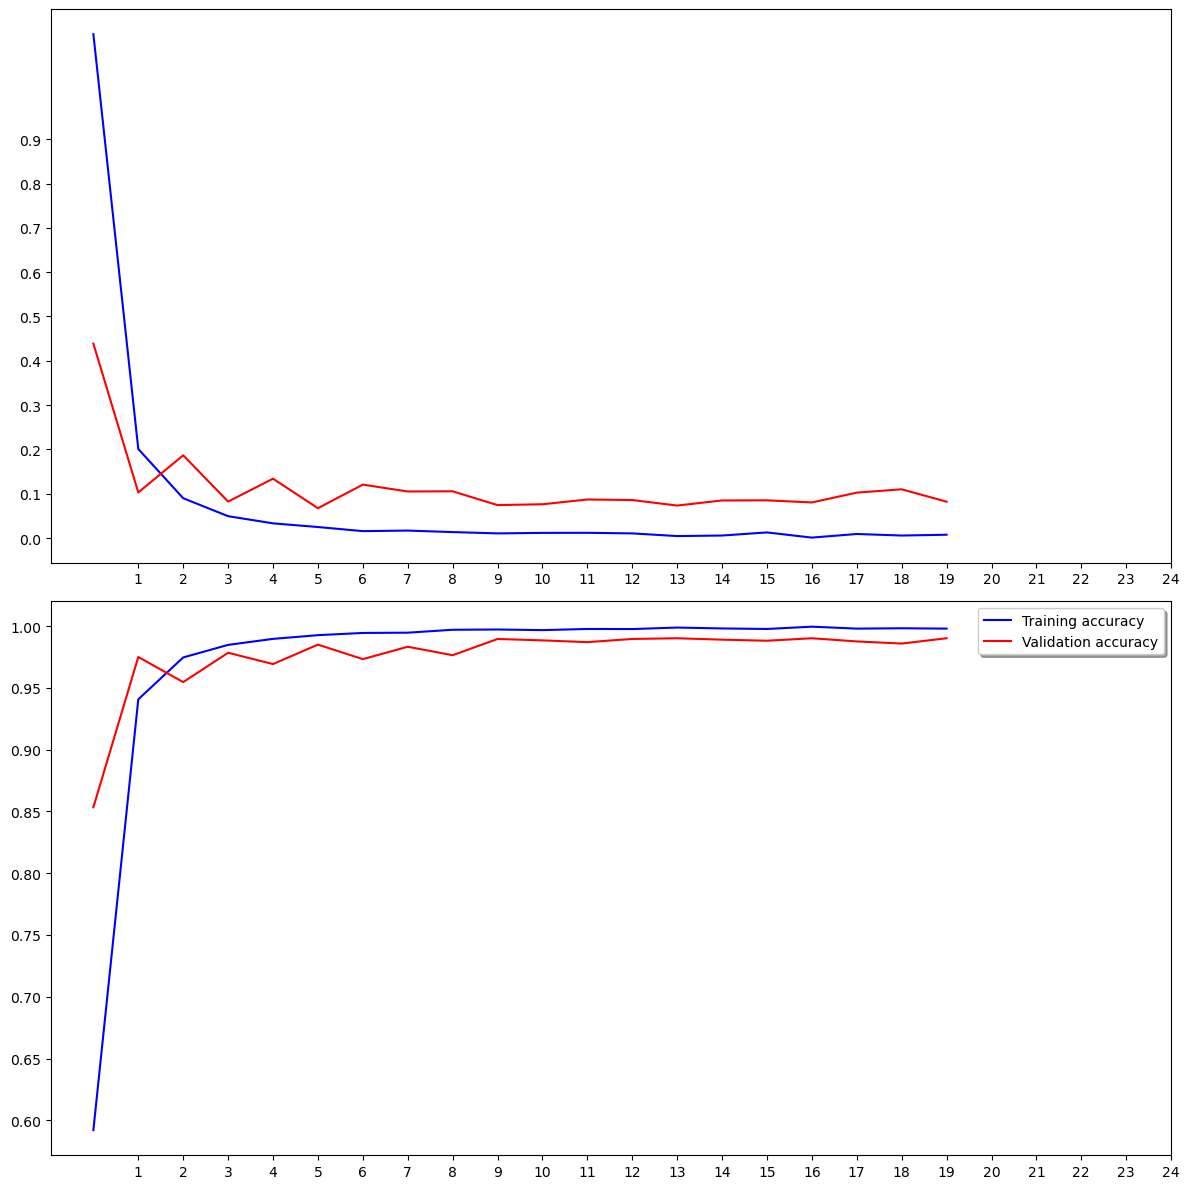

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


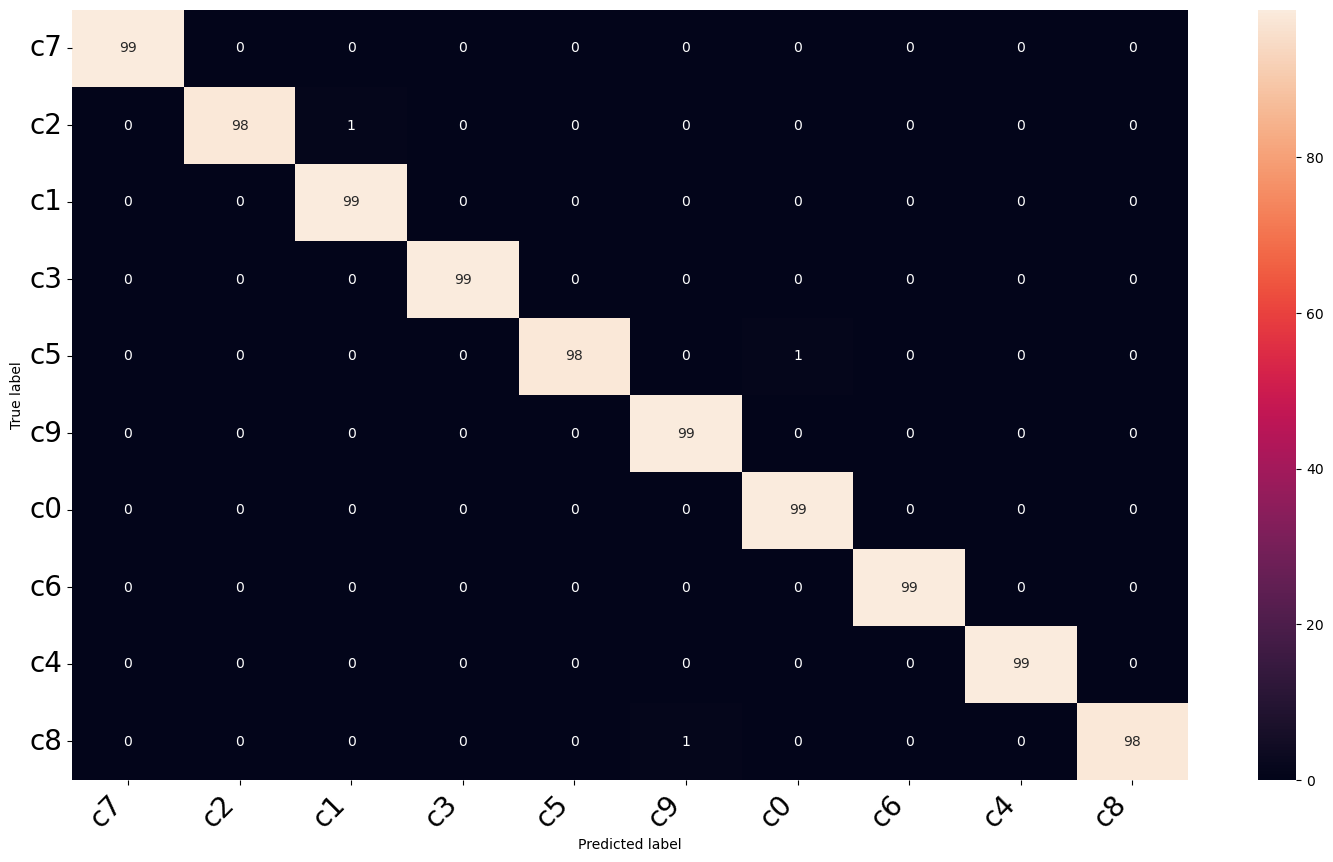

In [21]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = model.predict(valid_tensors)

print_heatmap(ytest,ypred,class_names)

In [22]:
#Precision Recall F1 Score

ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.990266
Precision: 0.990354
Recall: 0.990266
F1 score: 0.990279


In [23]:
BASE_MODEL_PATH = os.path.join(os.getcwd(),"model")
TEST_DIR = os.path.join(os.getcwd(),"csv_files","test.csv")
PREDICT_DIR = os.path.join(os.getcwd(),"pred_dir")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
JSON_DIR = os.path.join(os.getcwd(),"json_files")
if not os.path.exists(PREDICT_DIR):
    os.makedirs(PREDICT_DIR)
else:
    shutil.rmtree(PREDICT_DIR)
    os.makedirs(PREDICT_DIR)
if not os.path.exists(JSON_DIR):
    os.makedirs(JSON_DIR)

BEST_MODEL = os.path.join(BASE_MODEL_PATH,"self_trained","distracted-08-0.99.hdf5") #loading checkpoint with best accuracy and min epochs
model = load_model(BEST_MODEL)
model.summary()

C:\Users\Sync\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,368 (18.28 MB)

 Trainable params: 4,791,366 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
data_test = pd.read_csv(os.path.join(TEST_DIR))
#testing on the only 10000 images as loading the all test images requires ram>8gb
data_test = data_test[:10000] 
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4961 entries, 0 to 4960
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FileName   4961 non-null   object
 1   ClassName  4961 non-null   object
dtypes: object(2)
memory usage: 77.6+ KB


In [25]:
with open(os.path.join(PICKLE_DIR,"labels_list.pkl"),"rb") as handle:
    labels_id = pickle.load(handle)
print(labels_id)

{'c7': 0, 'c2': 1, 'c1': 2, 'c3': 3, 'c5': 4, 'c9': 5, 'c0': 6, 'c6': 7, 'c4': 8, 'c8': 9}


In [26]:
ImageFile.LOAD_TRUNCATED_IMAGES = True  
test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5

100%|██████████| 4961/4961 [00:09<00:00, 501.30it/s]


In [27]:
ypred_test = model.predict(test_tensors,verbose=1)
ypred_class = np.argmax(ypred_test,axis=1)

id_labels = dict()
for class_name,idx in labels_id.items():
    id_labels[idx] = class_name
print(id_labels)

for i in range(data_test.shape[0]):
    data_test.iloc[i,1] = id_labels[ypred_class[i]]

156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step
{0: 'c7', 1: 'c2', 2: 'c1', 3: 'c3', 4: 'c5', 5: 'c9', 6: 'c0', 7: 'c6', 8: 'c4', 9: 'c8'}


In [28]:
#to create a human readable and understandable class_name
import json
class_name = dict()
class_name["c0"] = "SAFE_DRIVING"
class_name["c1"] = "TEXTING_RIGHT"
class_name["c2"] = "TALKING_PHONE_RIGHT"
class_name["c3"] = "TEXTING_LEFT"
class_name["c4"] = "TALKING_PHONE_LEFT"
class_name["c5"] = "OPERATING_RADIO"
class_name["c6"] = "DRINKING"
class_name["c7"] = "REACHING_BEHIND"
class_name["c8"] = "HAIR_AND_MAKEUP"
class_name["c9"] = "TALKING_TO_PASSENGER"


with open(os.path.join(JSON_DIR,'class_name_map.json'),'w') as secret_input:
    json.dump(class_name,secret_input,indent=4,sort_keys=True)

In [30]:
# creating the prediction results for the image classification and shifting the predicted images to another folder
#with renamed filename having the class name predicted for that image using model
with open(os.path.join(JSON_DIR,'class_name_map.json')) as secret_input:
    info = json.load(secret_input)


for i in range(data_test.shape[0]):
    new_name = data_test.iloc[i,0].split("/")[-1].split(".")[0]+"_"+info[data_test.iloc[i,1]]+".jpg"
    shutil.copy(data_test.iloc[i,0],os.path.join(PREDICT_DIR,new_name))
    
#saving the model predicted results into a csv file
data_test.to_csv(os.path.join(os.getcwd(),"csv_files","short_test_result.csv"),index=False)